In [1]:



# %matplotlib widget

import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

import torch 
import torch.nn as nn 
import torch.optim as optim

# import torch_optimizer as optim_custom
from torch.utils.data import Dataset, DataLoader
from utils.bernstein_torch import bernstein_coeff_order10_new
# import scipy.io as sio

# from models.mlp_qp_vis_aware_2 import MLP, vis_aware_track_net, PointNet
# import pol_matrix_comp
# from tqdm import trange

from models.learned_optim_qcqp_3_2 import PointNet, CustomGRULayer, GRU_Hidden_State, MLP_Init, Learned_QCQP
from scipy.io import loadmat
import pol_matrix_comp

import bernstein_coeff_order10_arbitinterval
# torch.set_default_dtype(torch.float64)

In [2]:
t_fin = 10.0
num = 100
tot_time = np.linspace(0, t_fin, num)
tot_time_copy = tot_time.reshape(num, 1)


P_np, Pdot_np, Pddot_np = pol_matrix_comp.pol_matrix_comp(tot_time_copy)
#
# P_np, Pdot_np, Pddot_np = bernstein_coeff_order10_arbitinterval.bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)


nvar = np.shape(P_np)[1]

P = torch.from_numpy(P_np).float()
Pdot = torch.from_numpy(Pdot_np).float()
Pddot = torch.from_numpy(Pddot_np).float()

P_diag = torch.block_diag(P, P)
Pddot_diag = torch.block_diag(Pddot, Pddot)





num_obs = 8
num_circles = 3

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [4]:

data = loadmat('./dataset/goal_reaching_dataset_4.mat')

init_state_ego = data['init_state_ego']
goal_des = data['goal_des']
closest_obs = data['closest_obs']
v_obs = data['v_obs']
y_lane_bound = data['y_lane_bound']
y_lb = y_lane_bound[:, 0]
y_ub = y_lane_bound[:, 1]
param_des = data['param_des']
dim_x_obs = data['dim_x_obs']
dim_y_obs = data['dim_y_obs']
psi_obs = data['psi_obs']

# print(np.shape(dim_x_obs))


dataset_size = np.shape(init_state_ego)[0]

inp = np.hstack(( init_state_ego, goal_des, y_lane_bound   ))

inp_mean, inp_std = inp.mean(), inp.std()


pcd_data_temp = np.hstack(( closest_obs, dim_x_obs, dim_y_obs, v_obs, psi_obs  ))

# pcd_data = closest_obs.reshape(dataset_size, 2, num_obs   )

pcd_data = pcd_data_temp.reshape(dataset_size, 6, num_obs)


# pcd_data = closest_obs.reshape(dataset_size, 2, num_obs   )

min_pcd, max_pcd = pcd_data.min(), pcd_data.max()

pcd_mean, pcd_std = pcd_data.mean(), pcd_data.std()


In [5]:
# Custom Dataset Loader 
class TrajDataset(Dataset):
	"""Expert Trajectory Dataset."""
	def __init__(self, inp, init_state_ego, pcd_data, param_des, closest_obs, y_lane_bound, goal_des, psi_obs, dim_x_obs, dim_y_obs):
		
		# State Data
		self.inp = inp
  
		self.init_state_ego = init_state_ego
		
		# PCD Data
		self.pcd_data = pcd_data
		
		# Expert Coeff
		self.param_des = param_des
		
		self.closest_obs = closest_obs
  
		self.y_lane_bound = y_lane_bound
		self.goal_des = goal_des
		self.psi_obs = psi_obs 
		self.dim_x_obs = dim_x_obs 
		self.dim_y_obs = dim_y_obs

	
	def __len__(self):
		return len(self.inp)    
			
	def __getitem__(self, idx):
		
		# Inputs
		inp = self.inp[idx]
		init_state_ego = self.inp[idx]

		pcd_data = self.pcd_data[idx]
		
		# Outputs
		param_des = self.param_des[idx]
		
		closest_obs = self.closest_obs[idx]
  
		y_lane_bound = self.y_lane_bound[idx]
		goal_des = self.goal_des[idx]
		dim_x_obs = self.dim_x_obs[idx]
		dim_y_obs = self.dim_y_obs[idx] 
		psi_obs = self.psi_obs[idx]

  
  
		return torch.tensor(inp).float(), torch.tensor(init_state_ego).float(), torch.tensor(pcd_data).float(), torch.tensor(param_des).float(), torch.tensor(closest_obs).float(), torch.tensor(y_lane_bound).float(), torch.tensor(goal_des).float(),\
			   torch.tensor(psi_obs).float(), torch.tensor(dim_x_obs).float(), torch.tensor(dim_y_obs).float()		

# Batch Size - 3k or 4k
batch_size = 128

# pcd_data = pcd_data.reshape(data_set_size, 2, 200)

# Using PyTorch Dataloader
train_dataset = TrajDataset(inp, init_state_ego, pcd_data, param_des, closest_obs, y_lane_bound, goal_des, psi_obs, dim_x_obs, dim_y_obs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)


In [6]:

# Differentiable Layer
num_batch = 2


# Differentiable Layer
num_batch = train_loader.batch_size

P = P.to(device) 
Pdot = Pdot.to(device)
P_diag = P_diag.to(device)
Pddot_diag = Pddot_diag.to(device)

# PointNet
pcd_features = 40
point_net = PointNet(inp_channel=6, emb_dims=1024, output_channels=pcd_features)


mlp_init_inp_dim = np.shape(inp)[1]+pcd_features
mlp_init_hidden_dim = 256
# mlp_init_out_dim = (2*nvar)**2+2*nvar+2*nvar
mlp_init_out_dim = 2*nvar+2*num+2*(num_obs*num_circles*num+2*num)


#########################33

gru_input_size_s = 6*num
gru_hidden_size_s = 512
gru_output_size_s = 2*num
gru_context_s = CustomGRULayer(gru_input_size_s, gru_hidden_size_s, gru_output_size_s)

gru_input_size_lamda = 6*nvar
gru_hidden_size_lamda = 512
gru_output_size_lamda = 2*nvar
gru_context_lamda = CustomGRULayer(gru_input_size_lamda, gru_hidden_size_lamda, gru_output_size_lamda)

gru_input_size_alpha = 3*((num_obs*num_circles*num+2*num))
gru_hidden_size_alpha = 512
gru_output_size_alpha = num_obs*num_circles*num+2*num
gru_context_alpha = CustomGRULayer(gru_input_size_alpha, gru_hidden_size_alpha, gru_output_size_alpha)


gru_input_size_d = 3*((num_obs*num_circles*num+2*num))
gru_hidden_size_d = 512
gru_output_size_d = num_obs*num_circles*num+2*num
gru_context_d = CustomGRULayer(gru_input_size_d, gru_hidden_size_d, gru_output_size_d)


input_hidden_state_init_s = pcd_features+np.shape(inp)[1]
mid_hidden_state_init_s = 512
out_hidden_state_init_s = gru_hidden_size_s 
gru_init_s  =  GRU_Hidden_State(input_hidden_state_init_s, mid_hidden_state_init_s, out_hidden_state_init_s)


input_hidden_state_init_lamda = pcd_features+np.shape(inp)[1]
mid_hidden_state_init_lamda = 512
out_hidden_state_init_lamda = gru_hidden_size_lamda
gru_init_lamda  =  GRU_Hidden_State(input_hidden_state_init_lamda, mid_hidden_state_init_lamda, out_hidden_state_init_lamda)


input_hidden_state_init_alpha = pcd_features+np.shape(inp)[1]
mid_hidden_state_init_alpha = 512
out_hidden_state_init_alpha = gru_hidden_size_alpha
gru_init_alpha  =  GRU_Hidden_State(input_hidden_state_init_alpha, mid_hidden_state_init_alpha, out_hidden_state_init_alpha)


input_hidden_state_init_d = pcd_features+np.shape(inp)[1]
mid_hidden_state_init_d = 512
out_hidden_state_init_d = gru_hidden_size_d 
gru_init_d  =  GRU_Hidden_State(input_hidden_state_init_d, mid_hidden_state_init_d, out_hidden_state_init_d)

mlp_init = MLP_Init(mlp_init_inp_dim, mlp_init_hidden_dim, mlp_init_out_dim  )


model = Learned_QCQP(num_obs, t_fin, P, Pdot, Pddot, point_net, num_batch, min_pcd, max_pcd, inp_mean, inp_std, gru_context_alpha, gru_init_alpha, gru_context_d, gru_init_d, gru_context_s, gru_init_s, gru_context_lamda, gru_init_lamda,  mlp_init).to(device)
model.load_state_dict(torch.load('./weights/opt_surrogate_obs_avoidance_gru_new.pth'))
model.eval()


Learned_QCQP(
  (point_net): PointNet(
    (conv1): Conv1d(6, 64, kernel_size=(1,), stride=(1,), bias=False)
    (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
    (conv3): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
    (conv4): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
    (conv5): Conv1d(128, 1024, kernel_size=(1,), stride=(1,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=1024, out_features=256, bias=False)
    (bn6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_run

196
torch.Size([128])


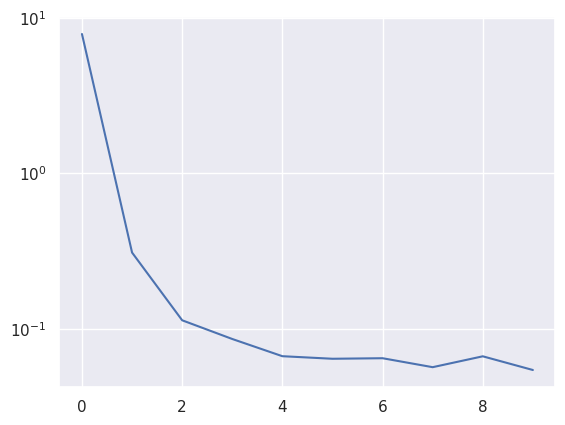

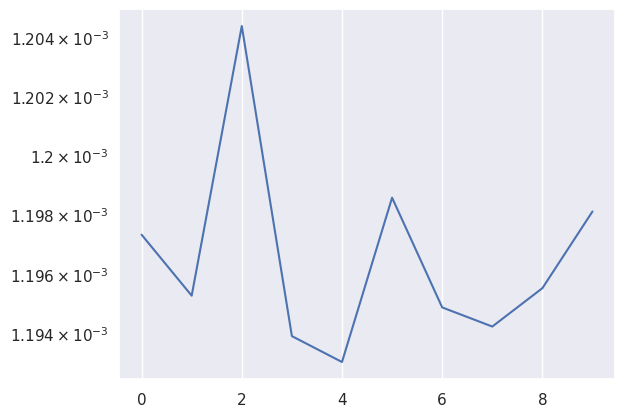

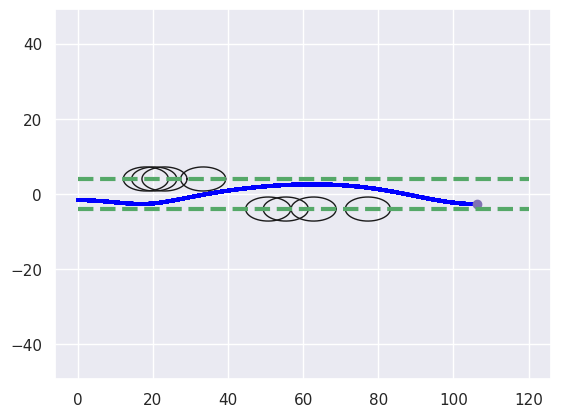

In [12]:
idx = np.random.randint(0, np.shape(closest_obs)[0])
# idx = 370
print(idx)

inp_test = inp[idx]
inp_test = torch.tensor(inp_test).float()
inp_test = inp_test.to(device)
inp_test = torch.vstack([inp_test] * num_batch)
inp_norm_test = (inp_test - inp_mean) / inp_std


closest_obs_test = closest_obs[idx]
closest_obs_test = torch.tensor(closest_obs_test).float()
closest_obs_test = closest_obs_test.to(device)
closest_obs_test = torch.vstack( [closest_obs_test]*num_batch  )



init_state_ego_test = init_state_ego[idx]
init_state_ego_test = torch.tensor(init_state_ego_test).float()
init_state_ego_test = init_state_ego_test.to(device)
init_state_ego_test = torch.vstack( [init_state_ego_test]*num_batch  )



pcd_test = pcd_data[idx]
pcd_test = torch.tensor(pcd_test).float()

pcd_test = pcd_test.to(device)
pcd_test = torch.vstack( [pcd_test]*num_batch  )
pcd_test = pcd_test.reshape(num_batch, 6, num_obs)

pcd_scaled = (pcd_test - min_pcd) / (max_pcd - min_pcd)

param_des_test = param_des[idx]
param_des_test = torch.tensor(param_des_test).float()
param_des_test = param_des_test.to(device)
param_des_test = torch.vstack( [param_des_test]*num_batch )



dim_x_obs_test = dim_x_obs[idx]
dim_x_obs_test = torch.tensor(dim_x_obs_test).float()
dim_x_obs_test = dim_x_obs_test.to(device)
dim_x_obs_test = torch.vstack( [dim_x_obs_test]*num_batch )



dim_y_obs_test = dim_y_obs[idx]
dim_y_obs_test = torch.tensor(dim_y_obs_test).float()
dim_y_obs_test = dim_y_obs_test.to(device)
dim_y_obs_test = torch.vstack( [dim_y_obs_test]*num_batch )



psi_obs_test = psi_obs[idx]
psi_obs_test = torch.tensor(psi_obs_test).float()
psi_obs_test = psi_obs_test.to(device)
psi_obs_test = torch.vstack( [psi_obs_test]*num_batch )


y_lb_test = y_lb[idx] 
y_lb_test = torch.tensor(y_lb_test).float()
y_lb_test = y_lb_test.to(device)
y_lb_test = torch.vstack([y_lb_test]*num_batch).squeeze() 


y_ub_test = y_ub[idx] 
y_ub_test = torch.tensor(y_ub_test).float()
y_ub_test = y_ub_test.to(device)
y_ub_test = torch.vstack([y_ub_test]*num_batch).squeeze()
print(y_ub_test.size())

goal_des_test = goal_des[idx]
goal_des_test = torch.tensor(goal_des_test).float()
goal_des_test = goal_des_test.to(device)
goal_des_test = torch.vstack( [goal_des_test]*num_batch )




with torch.no_grad():
    
    x_obs_circle_traj, y_obs_circle_traj, psi_obs_circle_traj = model.compute_obs_trajectories_batch(closest_obs_test, psi_obs_test, dim_x_obs_test, dim_y_obs_test)
    a_obs, b_obs = model.compute_obs_ellipse_batch(dim_x_obs_test, dim_y_obs_test)
    
    primal_sol, accumulated_res_primal, accumulated_res_fixed_point, res_primal_stack, res_fixed_point_stack = model.decoder_function(inp_norm_test, init_state_ego_test, pcd_scaled, x_obs_circle_traj, y_obs_circle_traj, a_obs, b_obs, y_ub_test, y_lb_test, param_des_test, goal_des_test)
	 



predict_traj = (P_diag @ primal_sol.T).T


th = np.linspace(0, torch.pi*2, 50)

x_obs_np = closest_obs_test[0, 0:num_obs].cpu().detach().numpy()
y_obs_np = closest_obs_test[0, num_obs:2*num_obs].cpu().detach().numpy()

plt.figure(1)
plt.plot(res_fixed_point_stack[:, 0].cpu().detach().numpy())
plt.yscale('log')


plt.figure(2)
plt.plot(res_primal_stack[:, 0].cpu().detach().numpy())
plt.yscale('log')

x_fin = goal_des_test[0, 0].cpu().detach().numpy()
y_fin = goal_des_test[0, 1].cpu().detach().numpy()


plt.figure(3)
plt.plot(predict_traj[:,0:100].T.cpu().detach().numpy(), predict_traj[:, 100:].T.cpu().detach().numpy(), color="blue", linewidth=2.5, label="Drone")
plt.plot(x_fin*np.ones(1), y_fin*np.ones(1), 'om')

for i in range(0, num_obs):
    x_ell = x_obs_np[i]+6.0*np.cos(th)
    y_ell = y_obs_np[i]+3.2*np.sin(th)
    plt.plot(x_ell, y_ell, '-k', linewidth = 1.0)
    
plt.plot(np.linspace(0, 120), -4*np.ones(50), '--g', linewidth = 3.0   )
plt.plot(np.linspace(0, 120), 4*np.ones(50), '--g', linewidth = 3.0   )

    


plt.axis('equal')
    


plt.show()